<a href="https://colab.research.google.com/github/RoseSarlake/Computer-Vision/blob/main/CV_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import needed packages

In [ ]:
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

In [ ]:
# import drive to access the test images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


some functions from assignment 1 

In [ ]:
# Gaussian kernel
def My_Gaussian(size,sigma):
  w = size 
  hw = (w-1)/2
  sum = 0
  g = np.zeros(w)
  for i in range(0,w):
    # The continuous normalization factor can be ignored since it disappears in the discrete normalization step
    g[i] = math.exp(-((i-hw)*(i-hw))/(2*sigma*sigma))
    sum += g[i]
  for i in range(0,w):
    g[i] /= sum
  return g

In [ ]:
def My_convolve2D(image, kernel, padding=0):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # get the image size and kernel size 
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int((xImgShape - xKernShape + 2 * padding) + 1)
    yOutput = int((yImgShape - yKernShape + 2 * padding) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply mirror padding
    if padding != 0:
        imagePadded = cv2.copyMakeBorder(image,padding,padding,padding,padding,cv2.BORDER_REFLECT)
        #print(imagePadded)
    else:
        imagePadded = image

    # Convolution
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
          output[x, y] = (kernel * imagePadded[x:x+xKernShape,y:y+yKernShape]).sum()
    return output

# 1.Harris derector

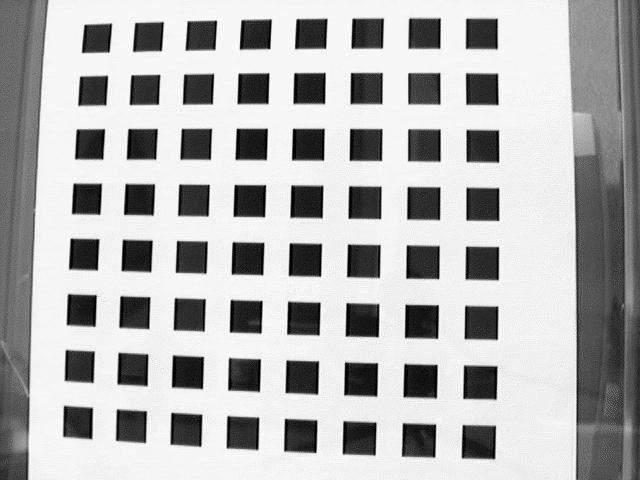

In [ ]:
imgD = cv2.imread("/content/drive/MyDrive/Colab/CV/images/CalibIm1.PNG")
imgd = cv2.cvtColor(imgD,cv2.COLOR_BGR2GRAY)
cv2_imshow(imgD)

a) Assume 𝜎0 = 0.5 as the smoothing of the input image. Compute the first derivative matrixes (Ix ,Iy) at a scale 𝜎𝐷 = 1.4𝜎0 . Differential masks of size 2 can be used.

In [ ]:
def my_harris_dxdy (sigma,img):
  # convert the input image to gray level 
  img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # calculate the smoothing kernel 
  kerv1 = My_Gaussian(5,sigma)
  # reverse it
  kerh1 = kerv1.reshape(kerv1.shape[0],1)
  # calculate the final 2d gaussian kernel
  kernel = kerv1*kerh1

  #smooth the image with the above kernel
  img_smooth = My_convolve2D(img_gray,kernel,padding=2)

  #  compute the first derivative
  Idx,Idy = np.gradient(img_smooth)

  # create a new kernel
  kerv2 = My_Gaussian(5,1.4*sigma)
  kerh2 = kerv2.reshape(kerv2.shape[0],1)
  kernel2 = kerv2*kerh2
  # smooth again, sigmaD = 1.4sigma0
  Ix = My_convolve2D(Idx,kernel2,padding=2)
  Iy = My_convolve2D(Idy,kernel2,padding=2)

  return Ix,Iy


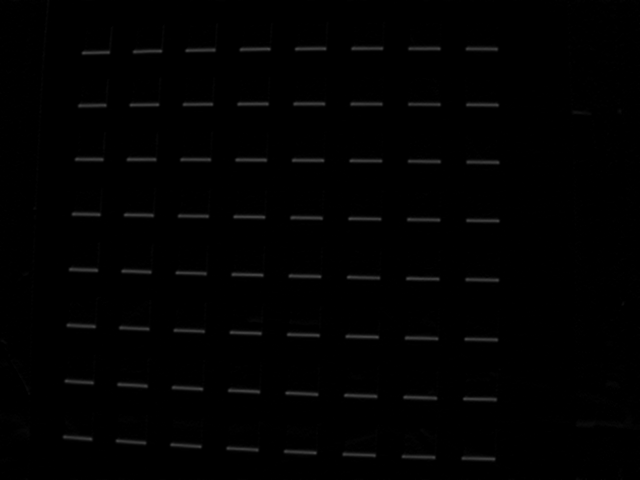

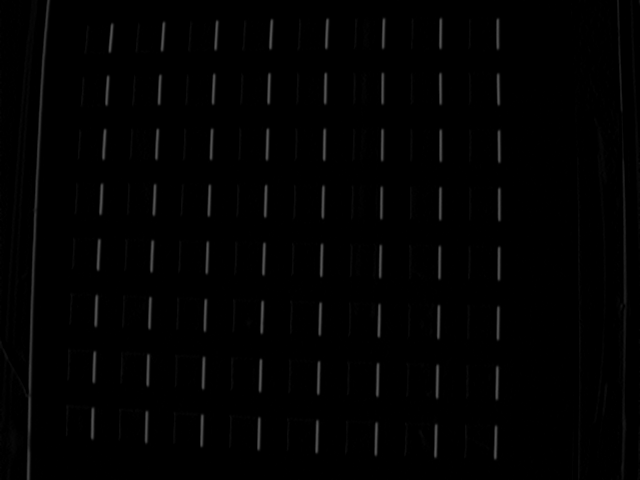

In [ ]:
# read a img
img1 = cv2.imread("/content/drive/MyDrive/Colab/CV/images/CalibIm1.PNG")

# call the function my_harris_dxdy, store the result in dx1,dy1
dx1,dy1 = my_harris_dxdy(0.5,img1)
# show the result
cv2_imshow(dx1)
cv2_imshow(dy1)

b) Compute the three matrixes: Ix2, Iy2, IxIy

In [ ]:
# from Idx,Idy in the 1 a), Ixx, Iyy, Ixy, Iyx  can be compute by numpy. 
def My_harris_xy(sigma,img):
  # call function my_harris_dxdy to get the dx and dy
  dx,dy = my_harris_dxdy (sigma,img)
  # Ix2 is the suqare of dx
  Ixx = np.square(dx)
  # Iy2 is the suqare of dy
  Iyy = np.square(dy)
  # (because Ixy == Iyx, only one need to be calculated)
  Ixy = np.multiply(dx,dy)
  
  return Ixx, Iyy, Ixy


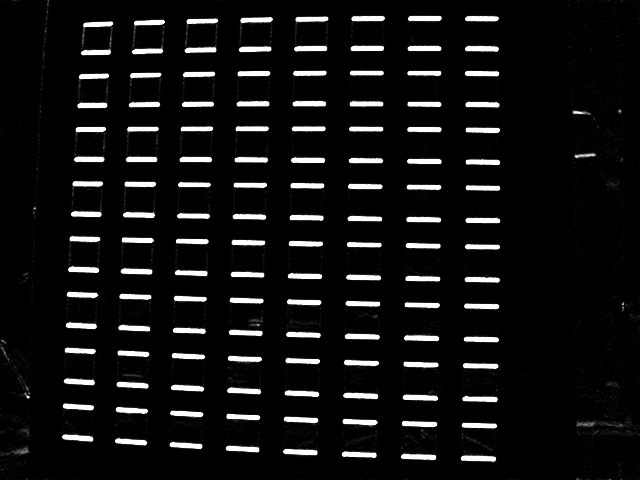

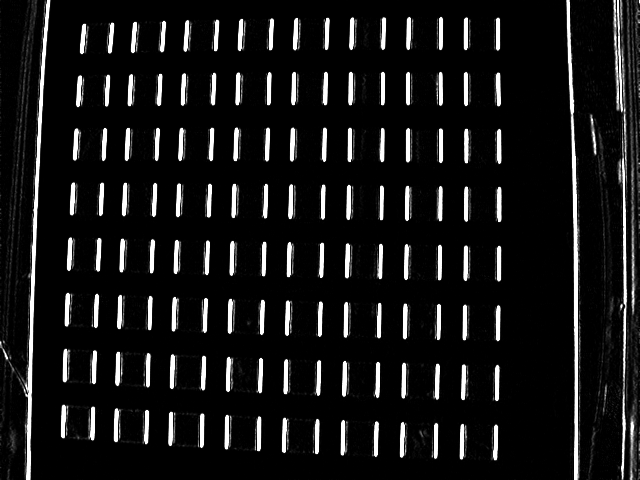

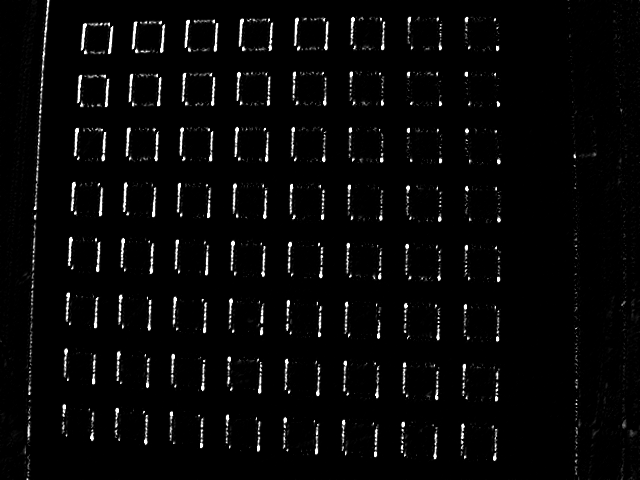

In [ ]:
# call the function My_harris_xy, store all three values as ixx, iyy and ixy
ixx,iyy,ixy = My_harris_xy(0.5,img1)
# show the result
cv2_imshow(ixx)
cv2_imshow(iyy)
cv2_imshow(ixy)

c) Compute at each pixel the terms of the second moment matrix by convolving the three matrices in point (c) with an isotropic Gaussian of 𝜎𝐼 = 1.5𝜎𝐷. Compute Trace and Determinant in each pixel

In [ ]:
def My_harris_3mat(sigma,img):
  # call function My_harris_xy to get Ixx, Iyy and Ixy value
  Ixx,Iyy,Ixy = My_harris_xy(sigma,img)
  # create a new gaussian kernel, where sigmaI = 1.5sigmaD
  kerv = My_Gaussian(5,sigma*1.4*1.5)
  kerh = kerv.reshape(kerv.shape[0],1)
  kernel = kerv*kerh

  # convolve the three matrices in point (c) with the kernel above
  Imgxx = My_convolve2D(Ixx, kernel, padding=2)
  Imgyy = My_convolve2D(Iyy, kernel, padding=2)
  Imgxy = My_convolve2D(Ixy, kernel, padding=2)

  return Imgxx, Imgyy, Imgxy

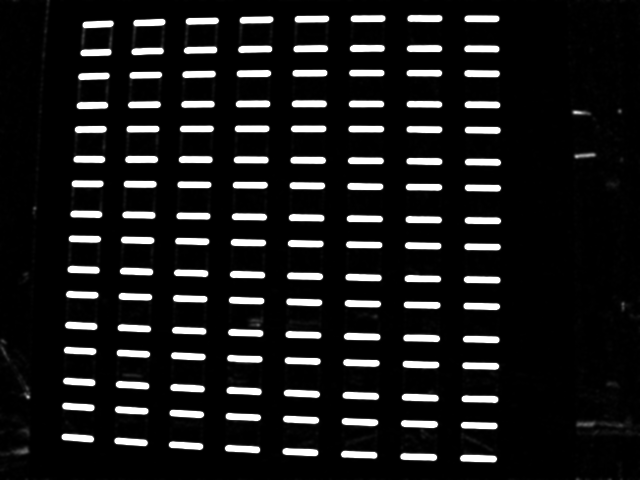

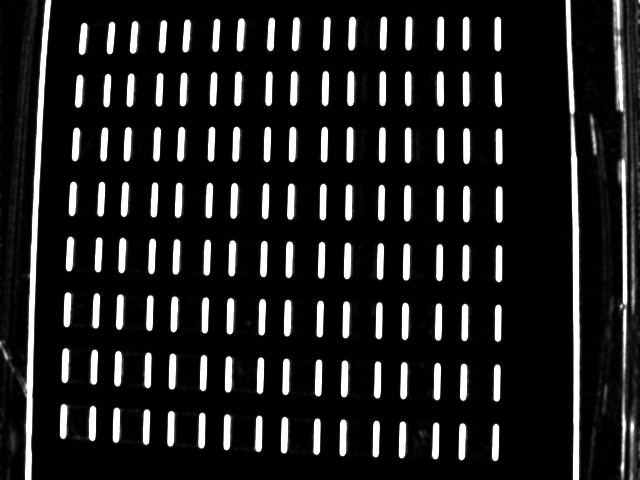

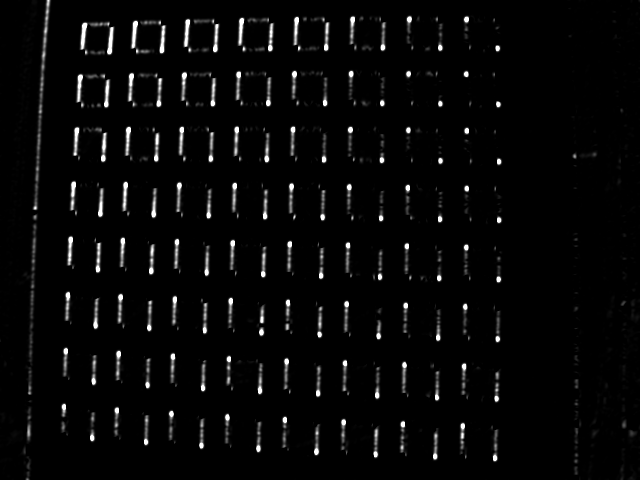

In [ ]:
# call the function My_harris_3mat, store all three values as imgxx, imgyy, imgxy
imgxx, imgyy, imgxy = My_harris_3mat(0.5,img1)
# show the result
cv2_imshow(imgxx)
cv2_imshow(imgyy)
cv2_imshow(imgxy)

In [ ]:
def My_harris_sqmat(sigma,img):
# call My_harris_3mat to get the filtered Imgxx, Imgyy and Imgxy
  Imgxx, Imgyy, Imgxy = My_harris_3mat(sigma,img)
  # imitialize variable res to store Harris-values
  res = np.zeros((img.shape[0],img.shape[1]),np.float32)
  # assume the k value is 0.04, 
  k = 0.04

  # for each pixel, calculate the second-moment matrix
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      # store the result in an array, which is a 2*2 matrix as follow:
      #   [Imgxx, Imgxy]
      #   [Imgxy, Imgyy]
      mat = np.array([[Imgxx[i][j], Imgxy[i][j]], 
               [Imgxy[i][j], Imgyy[i][j]]])
      # compute trace, which is the sum of Imgxx + sum of Imgyy
      # In numpy, "matrix.trace" can return the sum along diagonals of an array.
      trace = np.matrix.trace(mat)
      # compute determinant, which is the (sum of Imgxx * sum of Imgyy) - (sum of Imgxy**2)
      # In numpy, "linalg.det" can help to compute the determinant of an array
      deter = np.linalg.det(mat)

      # calculate the final response: res = deter - k*(trace**2)
      res[i][j]= deter - (k*np.square(trace))
      
  return res

d) Apply the Harris-corner criteria to compute the Harris-feature map

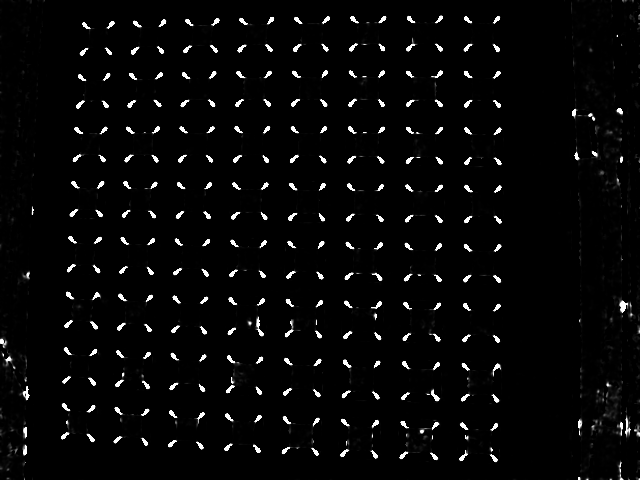

[[ 5.1403384e+00  7.0246387e+00  4.9868712e+00 ... -8.1765892e+01
  -6.0844684e+02 -2.0537253e+03]
 [ 3.8979754e+00  5.8940692e+00  4.9769063e+00 ... -4.5081776e+01
  -4.4151938e+02 -1.6771514e+03]
 [ 1.6621048e+00  2.8680108e+00  2.8878343e+00 ...  8.2166080e+00
  -1.3276151e+02 -8.0058405e+02]
 ...
 [ 2.6905837e+00  2.4269087e+00  1.4065955e+00 ...  3.7492508e+01
  -7.1793790e+00 -3.3111816e+01]
 [-6.4997607e-01  1.1031227e+00  1.1403555e+00 ...  5.7160976e+01
   7.1630585e+01  1.6146902e+02]
 [-5.3190598e+00 -8.4924573e-01  7.4551892e-01 ...  4.5486504e+01
   1.2299741e+02  2.4909543e+02]]


In [ ]:
# The final responses are computed in the 1 c)- My_harris_sqmat function, here apply it in a test image
feature = My_harris_sqmat(0.5,img1)
# show the image
cv2_imshow(feature)

e) Apply Non-Maxima suppression to identify true Harris points. Use 5 pixels as the minimum distance between maxima.

In [ ]:
# function that return the max value and its location
def My_harris_max(block):
  # In this function, assume the block is always 5*5

  # initialize the max value as center value of the block, and its location
  max = block[2][2]
  x = 2
  y = 2
# loop all the block to find the max value
  for i in range(0,5):
    for j in range(0,5):
      # if the current value is larger than max, store its location and value
      if block[i][j] > max:
        max = block[i][j]
        x = i
        y = j
  return x, y, max

In [ ]:
# check if it works
a = np.arange(25).reshape((5,5))
print(a)
My_harris_max(a)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


(4, 4, 24)

In [ ]:
# Non-Maxima suppression is used to restrict the minimum distance between adjacent Harris locations
# For example, if the mask size is 5*5, then in the 5*5 area, only one detected value can be stored


# input value "feat" is the feature map, "size" is the size*size empty mask
def My_harris_nonMax(feat,size):

 # get the feature image size
  height = feat.shape[0]
  width = feat.shape[1]
  # save the location of the detected point
  points = []
  # calculate the half size of mask size, which determine which pixel to start with
  hs = int(np.floor(size/2))

  # slide the mask into the feature image, with the step as same as mask size 
  # (because only one value need to be store in each block location, so do not need to slide on image pixel one by one)
  
  for i in range(hs,width-hs-1,size):
    for j in range(hs,height-hs-1,size):
      # get the current block 
      block_cur = feat[j-hs:j+hs+1,i-hs:i+hs+1]
      # call the My_harris_max function to find the max value of the current block
      x, y, max = My_harris_max(block_cur)
      # calculate the global location from the local location
      col = i + x - hs
      row = j + y - hs
      # store the result in the prepared list
      points.append((row, col, max))
     
  return points


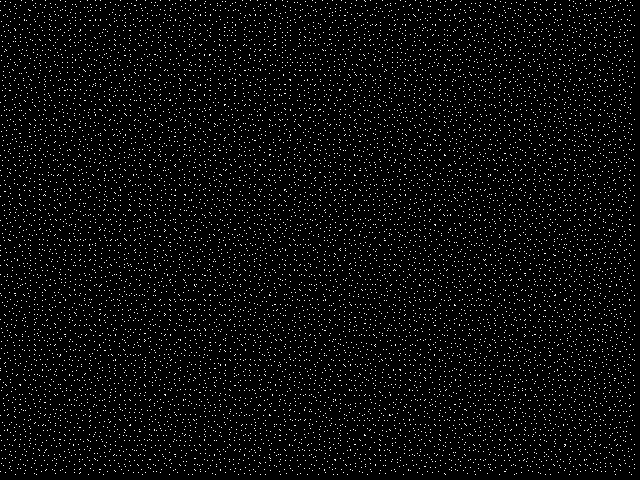

In [ ]:
# call the function My_harris_nonMax, generate the location list
point = My_harris_nonMax(feature,5)
# generate a black image with the same size of the feature
blk = np.zeros((feature.shape[0],feature.shape[1]),np.float32)
# set the point in selected location as 255, which will show as white point in the image
for i in range(len(point)):
  blk[point[i][0],point[i][1]] = 255
# show the result
cv2_imshow(blk)

f) Sort the local maxima to decrease the order of Harris-value and go through the list eliminating the weaker points at a distance less than a given threshold of one with a higher value 

In [76]:
# define a global variable THRESHOLD as the threshold of the Harris-value
THRESHOLD = 20
# This funtion improves the funtion "My_harris_max", add a threshold to remove the weaker points
def My_harris_thre(block):
  # In this function, assume the block is always 5*5
  # initialize the max value as center value of the block, and its location
  max = block[2][2]
  x = 2
  y = 2
# loop all the block to find the max value
  for i in range(0,5):
    for j in range(0,5):
      # if the current value is larger than max, store its location and value
      if block[i][j] > max:
        max = block[i][j]
        x = i
        y = j
  # only when the max value is higher than the threshold, the point can be saved
  if max>THRESHOLD:
    return x, y, max
 

In [ ]:
point_thre = My_harris_nonMax(feature,5)
print(len(point_thre))

12065


g) Fix a threshold to keep only with the first 1000 highest values.

In [89]:
# define how many highest values need to keep, here set the HIVAL = 1000
HIVAL = 1000

def My_harris_highset(feat,size):
  # call function My_harris_nonMax to get the detected points list
  pointlist = My_harris_nonMax(feat,size)
  # the point list store as [(x1,y1,harris_val1),(x2,y2,harris_val2),(x3,y3,harris_val3)...] 
  # each tuple of the list is the point's (x-axis,y-axis,harris value)
  # sort the tuple list from the highest to lowest based on the the harris value (tuple index 2)
  sortlist = sorted(pointlist, key = lambda tup : tup[2], reverse=True)
  # slice the sorted list, only keep the highest points 
  slicelist = sortlist[0:HIVAL]

  return slicelist


In [92]:
# call the function My_harris_highset
point_1000 = My_harris_highset(feature,5)
# check the length of the 
print(len(point_1000))
print(point_1000)


[(240, 294, 2203961.5), (126, 269, 2191533.0), (70, 299, 2155933.2), (390, 349, 2105247.8), (127, 239, 2075342.0), (302, 349, 2046173.0), (73, 269, 2042559.1), (219, 230, 2041760.9), (16, 329, 2041317.6), (49, 268, 2039807.1), (399, 401, 2032176.1), (306, 405, 2022819.4), (187, 291, 2022279.1), (185, 266, 2002320.6), (128, 294, 2000925.1), (185, 236, 1984363.2), (219, 347, 1972724.2), (236, 74, 1939416.1), (74, 324, 1927968.6), (131, 155, 1924173.6), (364, 255, 1912750.6), (304, 318, 1912285.6), (337, 376, 1907483.0), (296, 122, 1906959.9), (272, 264, 1896628.5), (248, 345, 1892837.8), (277, 407, 1891499.8), (155, 354, 1888987.2), (275, 320, 1887498.9), (128, 324, 1884896.1), (278, 346, 1882551.9), (189, 261, 1881779.1), (158, 324, 1879257.6), (396, 375, 1876120.4), (185, 352, 1869018.4), (301, 262, 1865877.5), (219, 261, 1860559.4), (134, 125, 1855939.9), (18, 354, 1853577.2), (21, 325, 1852752.6), (412, 174, 1842591.8), (299, 148, 1841422.8), (127, 184, 1838206.0), (45, 243, 1833843.

In [87]:
blk = np.zeros((feature.shape[0],feature.shape[1]),np.float32)
# set the point in selected location as 255, which will show as white point in the image
for i in range(len(point)):
  blk[point[i][0],point[i][1]] = 255
# show the result
cv2_imshow(blk)

[(240, 294, 2203961.5), (126, 269, 2191533.0), (70, 299, 2155933.2), (390, 349, 2105247.8), (127, 239, 2075342.0), (302, 349, 2046173.0), (73, 269, 2042559.1), (219, 230, 2041760.9), (16, 329, 2041317.6), (49, 268, 2039807.1), (399, 401, 2032176.1), (306, 405, 2022819.4), (187, 291, 2022279.1), (185, 266, 2002320.6), (128, 294, 2000925.1), (185, 236, 1984363.2), (219, 347, 1972724.2), (236, 74, 1939416.1), (74, 324, 1927968.6), (131, 155, 1924173.6), (364, 255, 1912750.6), (304, 318, 1912285.6), (337, 376, 1907483.0), (296, 122, 1906959.9), (272, 264, 1896628.5), (248, 345, 1892837.8), (277, 407, 1891499.8), (155, 354, 1888987.2), (275, 320, 1887498.9), (128, 324, 1884896.1), (278, 346, 1882551.9), (189, 261, 1881779.1), (158, 324, 1879257.6), (396, 375, 1876120.4), (185, 352, 1869018.4), (301, 262, 1865877.5), (219, 261, 1860559.4), (134, 125, 1855939.9), (18, 354, 1853577.2), (21, 325, 1852752.6), (412, 174, 1842591.8), (299, 148, 1841422.8), (127, 184, 1838206.0), (45, 243, 1833843.

h) Refine the spatial coordinates of each KeyPoint using OpenCV's function cornerSubPix on a window of size 5x5.

# Orientation and Display

h) Extract a signature vector, 𝑆𝑉 = (𝑥, 𝑦, 𝜃, 𝜆1, 𝜆2, 𝜎𝐼), for each Harris-point. Compute the 
region orientation 𝜃 using the angle between the eigenvector associated to the highest eigenvalue (the semi-major axis of the ellipse) and the axis x of the image

i) Show all detected points drawing on the original image circles of radius proportional to the detection scale 𝜎𝐼 with an radio point out to the direction of 𝜃 (Hint: compute KeyPoints and use drawKeyPoints ()).

j) Show again all detected points but now drawing ellipses instead of circles and using for it the information the first five values of the signature vector. (Hint: use ellipse())

# Region rectification

k) Compute the isometric rectified local regions associated with Harris point integration regions. Use Baumberg’s algorithm and the Cholesky decomposition. Normalize the intensity graylevel to || ||F=1 (Frobenius’s norm)

l) Show in a panel with at least 10 original and rectified regions. As the integrations regions will be too small apply a 10x interpolation to increase the 
size.

# BONUS

m) Construct a four-level Gaussian Scale-space. Assume 𝜎0 = 0.5 𝑎𝑛𝑑 𝜎𝑘 = 1.4 × 𝜎𝑘−1, 𝑘 = 1,2,3,4, as smoothing sigma on each scale. These sigma values fix 
the scale 𝜎𝐷 of the derivative on each level. Apply the above process to all pyramid levels selecting the most representatives regions from each level to a total of 1500. Show the result.